## How to: Calibrate the age-action model using an external sample of stars and their ages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import jax.numpy as jnp

import zoomies

%load_ext autoreload
%autoreload 2

# Stokholm RGB Sample

First, we read in a calibration sample of red giant branch stars with asteroseismic ages, crossmatched with Gaia.

Table from Stokholm et al. 2023 https://ui.adsabs.harvard.edu/abs/2023MNRAS.524.1634S/abstract

In [2]:
xmatch = Table.read('../../StokholmRGB_GaiaXmatch.csv')

# No negative parallaxes
xmatch = xmatch[xmatch['parallax'] > 0]

The function ``calc_jz()`` calculates and saves actions (J_z, J_r, and J_phi) for calibration samples.

(This step will take a while for large samples)

In [3]:
zoomies.calc_jz(xmatch,  mwmodel='2022', method='agama', write=True, fname='../../FinalFinalCode/Final_datafiles/StokholmRGB_GaiaXmatch_WithActions_2022.fits')

Read saved table with actions back in:

In [4]:
xmatch = Table.read('../../FinalFinalCode/Final_datafiles/StokholmRGB_GaiaXmatch_WithActions_2022.fits')

In [ ]:

# # No Nan Jzs
# # xmatch = xmatch[~np.isnan(xmatch['Jz'])]

# # No Unreasonably large Jzs
# xmatch = xmatch[np.log(xmatch['Jz']) < 20]

We calculate an age error column from the percentile values given. We don't want negative or zero age errors.

In [5]:
xmatch['age_err'] = np.nanmean((xmatch['LOWER_ERROR_AGE_BASTA']/1000, xmatch['UPPER_ERROR_AGE_BASTA']/1000), axis=0)
xmatch = xmatch[xmatch['age_err'] > 0]

Write the filtered table again -- now can read in the table without doing any more cuts.

Writing/reading in the tables like this is optional, but it allows you to perform analysis only on the saved tables with calculated actions (without calculating the actions again)

In [7]:
xmatch.write('../../FinalFinalCode/Final_datafiles/StokholmRGB_GaiaXmatch_WithActions_2022.fits', overwrite=True)

Start from here if you don't want to do all the calculations again

In [8]:
xmatch = Table.read('../../FinalFinalCode/Final_datafiles/2_StokholmRGB_GaiaXmatch_WithActions_2022.fits')

Defining age, ln(J_z), and age error arrays

In [10]:
age = np.array(xmatch['AGE_BASTA'])/1000 # Age in Gyr
lnJz = np.array(np.log(xmatch['Jz']))
age_err = np.array(xmatch['age_err'])

Plot the calibration sample in age--action space:

Text(0.5, 1.0, 'RGB Calibration Sample')

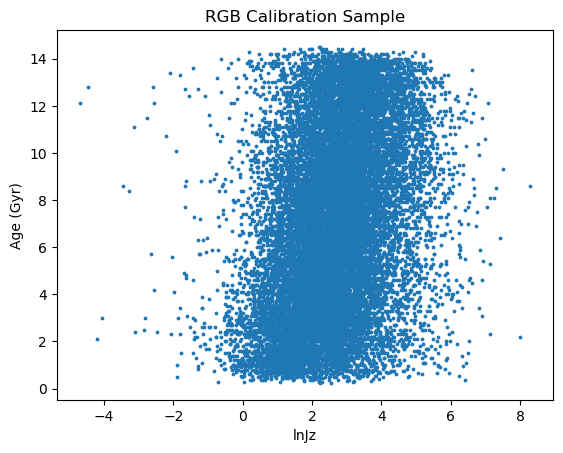

In [11]:
# Calibration sample in age-lnJz space
plt.scatter(lnJz, age, s=3)
plt.xlabel('lnJz')
plt.ylabel('Age (Gyr)')
plt.title('RGB Calibration Sample')

### Calibrating the monotonic age-lnJz spline model

First, define a KinematicAgeSpline object using ``jax`` arrays of the age, age_error, and lnJz variables we defined above:

In [12]:
spline = zoomies.KinematicAgeSpline(jnp.array(lnJz), jnp.array(age), jnp.array(age_err))

With ``spline.fit_mono_spline``, you can fit the age--action model (including a monotonic age--lnJz spline) using the calibration sample in one step. 

In [13]:
spline.fit_mono_spline(num_warmup=2000, num_samples=2000)

Fitting line...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Let's plot our spline model against the calibration data:

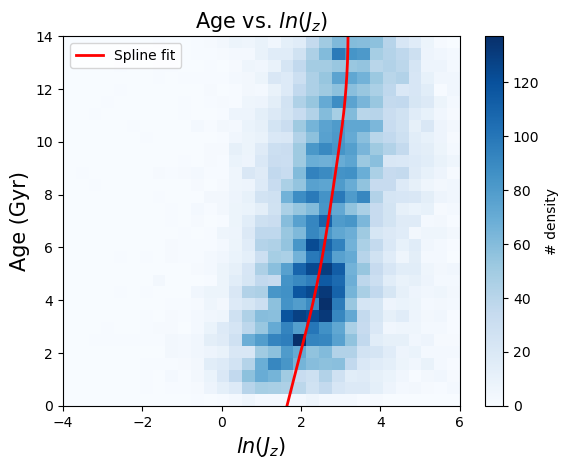

In [14]:
spline.plot_fit()

We can take a look at the sample statistics using ``spline.inf_data``:

In [17]:
import arviz as az
az.summary(spline.inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V,1.314,0.013,1.290,1.338,0.000,0.000,4677.0,2417.0,1.0
age_knot_vals[0],1.530,0.046,1.440,1.613,0.001,0.001,1564.0,2507.0,1.0
age_knot_vals[1],0.158,0.011,0.137,0.179,0.000,0.000,1394.0,2181.0,1.0
age_knot_vals[2],0.110,0.011,0.091,0.131,0.000,0.000,1432.0,2191.0,1.0
age_knot_vals[3],0.093,0.010,0.074,0.112,0.000,0.000,2071.0,2473.0,1.0
age_knot_vals[4],0.010,0.009,0.000,0.026,0.000,0.000,2477.0,1763.0,1.0
dens_knot_vals[0],-9.728,0.264,-10.000,-9.236,0.004,0.003,2762.0,1747.0,1.0
dens_knot_vals[1],4.698,0.079,4.560,4.857,0.001,0.001,4029.0,3042.0,1.0
dens_knot_vals[2],7.166,0.030,7.112,7.223,0.000,0.000,4753.0,2725.0,1.0
dens_knot_vals[3],7.512,0.024,7.466,7.556,0.000,0.000,5352.0,3237.0,1.0


Let's write the calibrated model:

In [15]:
spline.write(directory='../RGB_spline_model/')

And read it back in just for fun

In [16]:
newspline = zoomies.read(directory='../RGB_spline_model/')

``newspline`` has all the same attributes as ``spline``, so you can fit the model once and read it in again and again to generate age predictions for other stars.

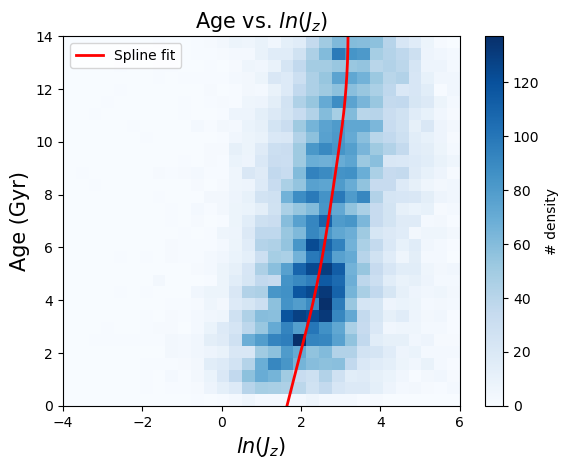

In [17]:
newspline.plot_fit()

Using the ``KinematicAgeSpline.evaluate_ages()`` function, you can generate a predicted age probability distribution for any value of ln($J_z$).

``evaluate_ages()`` returns two things:

``eval_grid`` is the test age array upon which the age probabilities are evaluated.

``eval_pdf`` is the kinematic age probability at each point in ``eval_grid``.

Plotting ``eval_pdf`` vs. ``eval_grid`` gives you the kinematic age probability density function.

In [18]:
# evaluate_ages() takes an argument of ln(Jz).

eval_grid, eval_pdf_m3 = newspline.evaluate_ages(-3)
_, eval_pdf_m1 = newspline.evaluate_ages(-1)
_, eval_pdf_0 = newspline.evaluate_ages(0)
_, eval_pdf_1 = newspline.evaluate_ages(1)
_, eval_pdf_2 = newspline.evaluate_ages(2)
_, eval_pdf_3 = newspline.evaluate_ages(3)
_, eval_pdf_4 = newspline.evaluate_ages(4)
_, eval_pdf_5 = newspline.evaluate_ages(5)

Text(0.5, 1.0, 'Age Predictions for Test $ln(J_z) Values$')

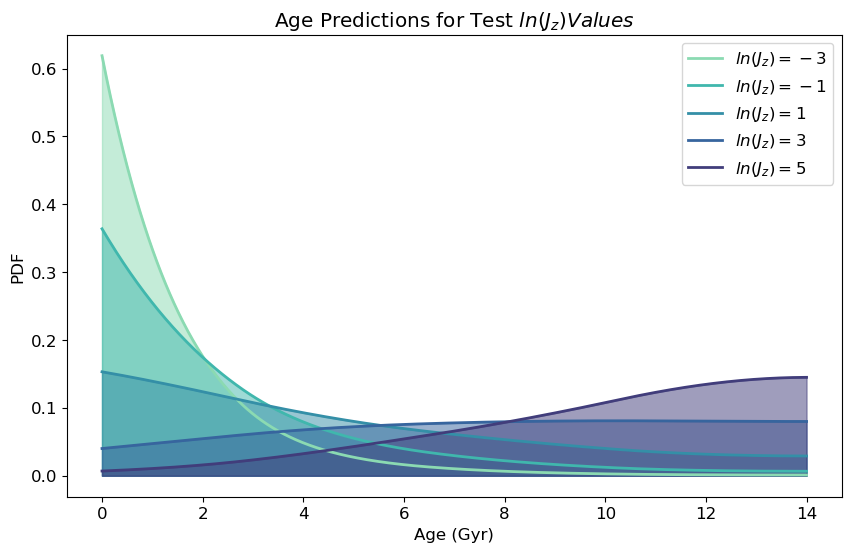

In [19]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

plt.plot(eval_grid, eval_pdf_m3, label='$ln(J_z)=-3$', color=sns.color_palette("mako_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, eval_pdf_m1, label='$ln(J_z)=-1$', color=sns.color_palette("mako_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, eval_pdf_1, label='$ln(J_z) = 1 $', color=sns.color_palette("mako_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, eval_pdf_3, label='$ln(J_z) = 3 $', color=sns.color_palette("mako_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, eval_pdf_5, label='$ln(J_z) = 5 $', color=sns.color_palette("mako_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, eval_pdf_m3, 0, color=sns.color_palette("mako_r").as_hex()[0], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_m1, 0, color=sns.color_palette("mako_r").as_hex()[1], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_1, 0, color=sns.color_palette("mako_r").as_hex()[2], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_3, 0, color=sns.color_palette("mako_r").as_hex()[3], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_5, 0, color=sns.color_palette("mako_r").as_hex()[4], alpha=.5)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for Test $ln(J_z) Values$')

In [20]:
kepler_ages = Table.read('../../Kepler_Age_Predictions.fits')
kep42 = np.log(kepler_ages[kepler_ages['kepid'] == 8561063]['Jz'])
kep125 = np.log(kepler_ages[kepler_ages['kepid'] == 10489206]['Jz'])
kep186 = np.log(kepler_ages[kepler_ages['kepid'] == 8120608]['Jz'])
kep249 = np.log(kepler_ages[kepler_ages['kepid'] == 7907423]['Jz'])
kep236 = np.log(kepler_ages[kepler_ages['kepid'] == 4725681]['Jz'])

In [24]:
# kep42 = 3.6486240894109683
# kep125 = -0.9615162137394352
# kep186 = -1.657133801967237
# kep249 = 0.9103696829926338
# kep236 = -0.39834222813493686

Text(0.5, 1.0, 'Age Predictions for M Dwarf Planet Hosts')

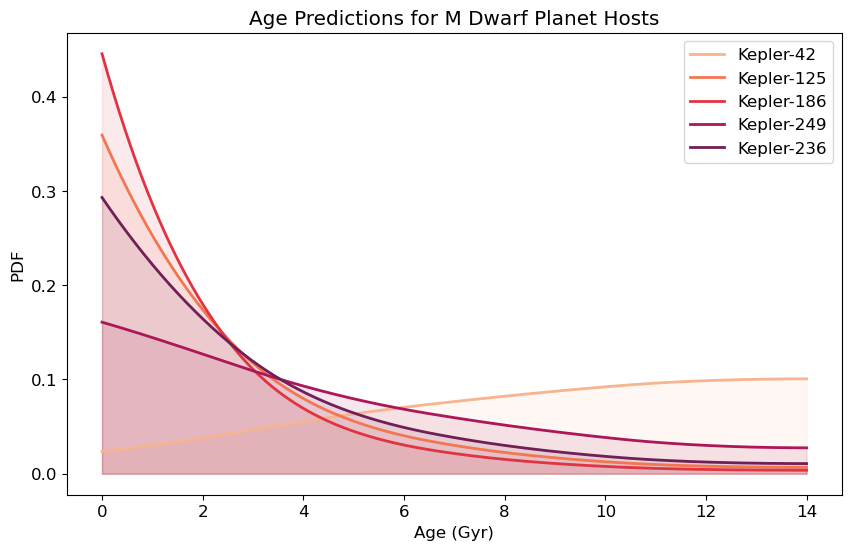

In [25]:
eval_grid, eval_pdf_kep42 = spline.evaluate_ages(kep42)
_, eval_pdf_kep125 = spline.evaluate_ages(kep125)
_, eval_pdf_kep186 = spline.evaluate_ages(kep186)
_, eval_pdf_kep249 = spline.evaluate_ages(kep249)
_, eval_pdf_kep236 = spline.evaluate_ages(kep236)


import seaborn as sns

plt.plot(eval_grid, eval_pdf_kep42, label='Kepler-42', color=sns.color_palette("rocket_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep125, label='Kepler-125', color=sns.color_palette("rocket_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep186, label='Kepler-186', color=sns.color_palette("rocket_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep249, label='Kepler-249', color=sns.color_palette("rocket_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep236, label='Kepler-236', color=sns.color_palette("rocket_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, eval_pdf_kep42, 0, color=sns.color_palette("rocket_r").as_hex()[0], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep125, 0, color=sns.color_palette("rocket_r").as_hex()[1], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep186, 0, color=sns.color_palette("rocket_r").as_hex()[2], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep249, 0, color=sns.color_palette("rocket_r").as_hex()[3], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep236, 0, color=sns.color_palette("rocket_r").as_hex()[4], alpha=0.1)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for M Dwarf Planet Hosts')

# StarHorse APOGEE Sample

Read in data and calculate actions

In [3]:
# # Reading calibration sample of MSTO stars with ages, crossmatched with Gaia
starhorse_apogee = Table.read('../../../starhorse_data/StarHorse_APOGEE_composite.ecsv')
starhorse_apogee = starhorse_apogee[starhorse_apogee['StarHorse_AGE_INOUT'] != 'Warn_diff_inout']

# # No negative parallaxes
starhorse_apogee = starhorse_apogee[starhorse_apogee['parallax'] > 0]

# # Calculate actions for calibration stars and save
# # This step will take a while for large samples
# zoomies.calc_jz(starhorse_apogee, mwmodel='2022', method='agama', write=True, fname='../../FinalFinalCode/Final_datafiles/StarHorse_APOGEE_composite_WithActions_2022.fits')

In [4]:
# Read table back in
starhorse_apogee = Table.read('../../FinalFinalCode/Final_datafiles/StarHorse_APOGEE_composite_WithActions_2022.fits')

# No Nan Jzs
# starhorse_apogee = starhorse_apogee[~np.isnan(starhorse_apogee['Jz'])]

# No Unreasonably large Jzs
starhorse_apogee = starhorse_apogee[np.log(starhorse_apogee['Jz']) < 20]

# Calculate an age error column -- we don't want negative or zero age errors.
starhorse_apogee['age_err'] = np.array(np.nanmean((starhorse_apogee['age50']-starhorse_apogee['age16'], starhorse_apogee['age84']-starhorse_apogee['age50']), axis=0))
starhorse_apogee = starhorse_apogee[starhorse_apogee['age_err'] > 0]

# Write filtered table again -- now can read in the table without doing any more cuts
starhorse_apogee.write('../../FinalFinalCode/Final_datafiles/StarHorse_APOGEE_composite_WithActions_2022.fits', overwrite=True)

Start from here if you don't want to do all the calculations again

In [14]:
starhorse_apogee = Table.read('../../FinalFinalCode/Final_datafiles/StarHorse_APOGEE_composite_WithActions_2022.fits')

In [15]:
age = np.array(starhorse_apogee['age50'])
age_err = np.mean((starhorse_apogee['age50'] - starhorse_apogee['age16'], starhorse_apogee['age84'] - starhorse_apogee['age50']), axis=0)
lnJz = np.array(np.log(starhorse_apogee['Jz']))

In [16]:
np.median(age_err)

0.5330031

Text(0.5, 1.0, 'MSTO Calibration Sample')

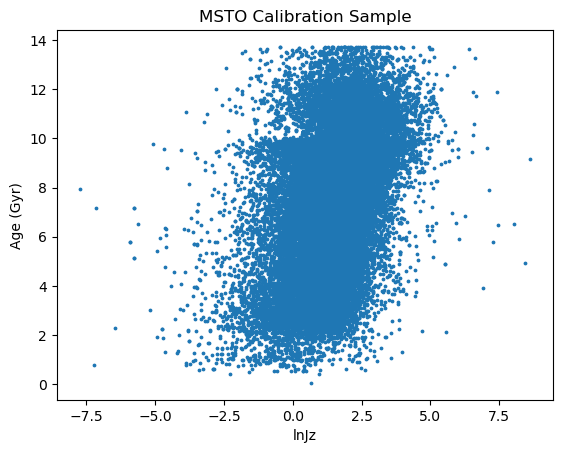

In [17]:
plt.scatter(lnJz, age, s=3)

plt.xlabel('lnJz')
plt.ylabel('Age (Gyr)')

plt.title('MSTO Calibration Sample')

Calibrate monotonic spline model

In [18]:
import jax.numpy as jnp
spline = zoomies.KinematicAgeSpline(jnp.array(lnJz), jnp.array(age), jnp.array(age_err))
spline.fit_mono_spline(num_warmup=2000, num_samples=2000)

Fitting line...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

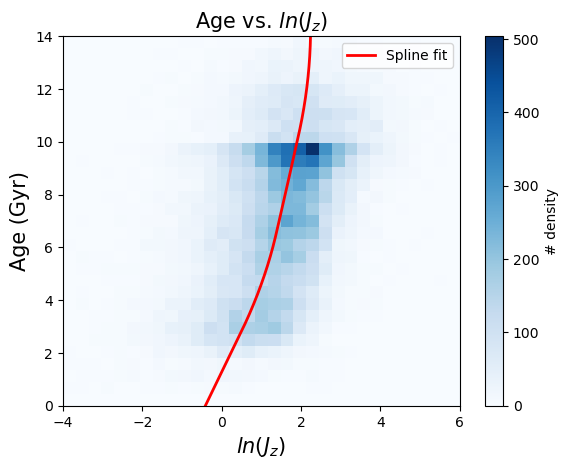

In [19]:
spline.plot_fit()

In [20]:
import arviz as az
az.summary(spline.inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V,1.255,0.010,1.236,1.271,0.000,0.000,5664.0,2654.0,1.0
age_knot_vals[0],-0.761,0.062,-0.875,-0.640,0.001,0.001,2114.0,2235.0,1.0
age_knot_vals[1],0.331,0.014,0.306,0.358,0.000,0.000,1926.0,2156.0,1.0
age_knot_vals[2],0.151,0.009,0.135,0.167,0.000,0.000,1907.0,2612.0,1.0
age_knot_vals[3],0.142,0.009,0.125,0.159,0.000,0.000,3091.0,2561.0,1.0
age_knot_vals[4],0.006,0.006,0.000,0.016,0.000,0.000,4390.0,2103.0,1.0
dens_knot_vals[0],-9.359,0.644,-10.000,-8.180,0.008,0.006,3653.0,1761.0,1.0
dens_knot_vals[1],3.329,0.165,3.011,3.626,0.002,0.002,5271.0,2821.0,1.0
dens_knot_vals[2],5.670,0.051,5.578,5.770,0.001,0.000,5983.0,2915.0,1.0
dens_knot_vals[3],7.612,0.024,7.566,7.655,0.000,0.000,7398.0,2942.0,1.0


In [23]:
spline.write(directory='../MSTO_spline_model/')

In [24]:
newspline = zoomies.read(directory='../MSTO_spline_model/')

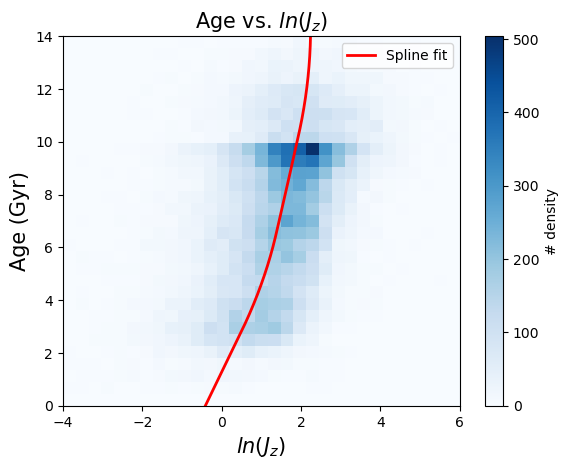

In [25]:
newspline.plot_fit()

In [26]:
eval_grid, eval_pdf_m3 = newspline.evaluate_ages(-3)
_, eval_pdf_m1 = newspline.evaluate_ages(-1)
_, eval_pdf_0 = newspline.evaluate_ages(0)
_, eval_pdf_1 = newspline.evaluate_ages(1)
_, eval_pdf_2 = newspline.evaluate_ages(2)
_, eval_pdf_3 = newspline.evaluate_ages(3)
_, eval_pdf_4 = newspline.evaluate_ages(4)
_, eval_pdf_5 = newspline.evaluate_ages(5)

Text(0.5, 1.0, 'Age Predictions for Test $ln(J_z) Values$')

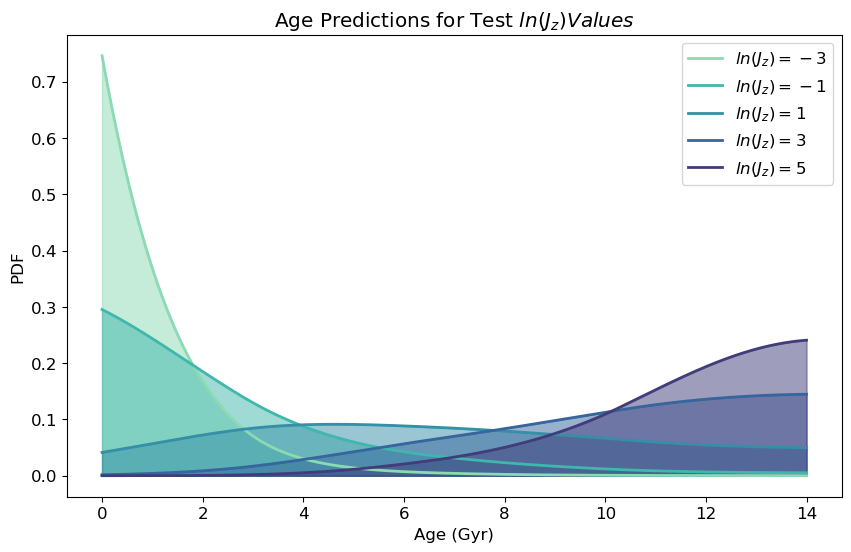

In [27]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

plt.plot(eval_grid, eval_pdf_m3, label='$ln(J_z)=-3$', color=sns.color_palette("mako_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, eval_pdf_m1, label='$ln(J_z)=-1$', color=sns.color_palette("mako_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, eval_pdf_1, label='$ln(J_z) = 1 $', color=sns.color_palette("mako_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, eval_pdf_3, label='$ln(J_z) = 3 $', color=sns.color_palette("mako_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, eval_pdf_5, label='$ln(J_z) = 5 $', color=sns.color_palette("mako_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, eval_pdf_m3, 0, color=sns.color_palette("mako_r").as_hex()[0], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_m1, 0, color=sns.color_palette("mako_r").as_hex()[1], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_1, 0, color=sns.color_palette("mako_r").as_hex()[2], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_3, 0, color=sns.color_palette("mako_r").as_hex()[3], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_5, 0, color=sns.color_palette("mako_r").as_hex()[4], alpha=.5)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for Test $ln(J_z) Values$')